<a href="https://colab.research.google.com/github/AMJAMAITHILI/ML_LAB-141/blob/main/sih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

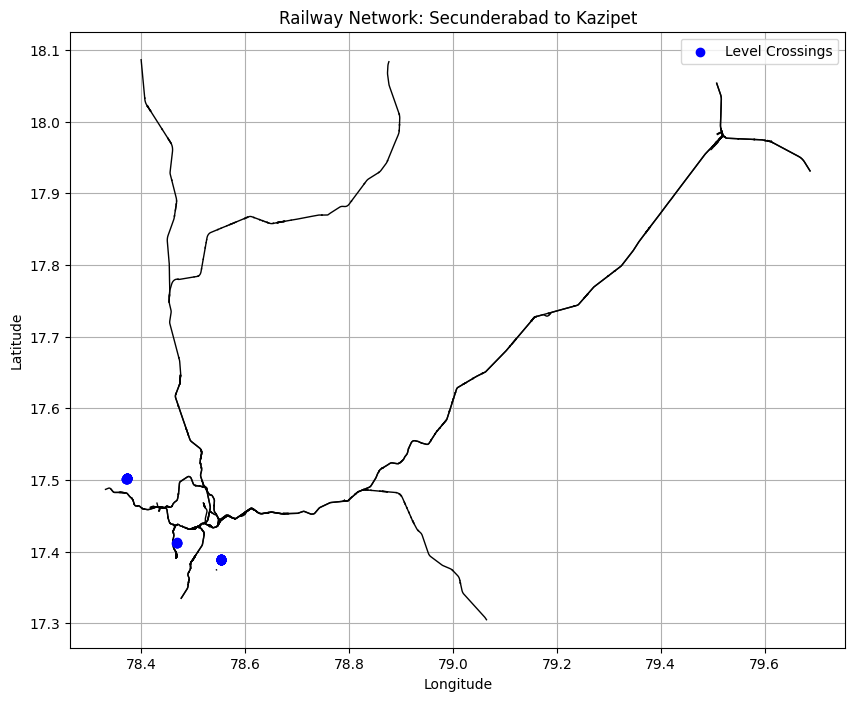

In [1]:
import requests
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Define bounding box
# -------------------------------
south, west = 17.35, 78.35
north, east = 18.05, 79.65

# -------------------------------
# Step 2: Build Overpass QL query
# -------------------------------
ql = f"""
[out:json][timeout:25];
(
  way["railway"="rail"]({south},{west},{north},{east});
  node["railway"="signal"]({south},{west},{north},{east});
  node["railway"="level_crossing"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

# -------------------------------
# Step 3: Fetch data from Overpass
# -------------------------------
OVERPASS_URL = "https://overpass-api.de/api/interpreter"
response = requests.post(OVERPASS_URL, data={"data": ql}, timeout=60)
osmd = response.json()

# -------------------------------
# Step 4: Separate nodes and ways
# -------------------------------
nodes = {}
ways = []

for elem in osmd['elements']:
    if elem['type'] == 'node':
        nodes[elem['id']] = {
            "lat": elem['lat'],
            "lon": elem['lon'],
            "tags": elem.get('tags', {})
        }
    elif elem['type'] == 'way':
        ways.append({
            "id": elem['id'],
            "nodes": elem['nodes'],
            "tags": elem.get('tags', {})
        })

# -------------------------------
# Step 5: Extract railway track lines
# -------------------------------
track_lines = []
for way in ways:
    if way['tags'].get('railway') == 'rail':
        line_coords = []
        for node_id in way['nodes']:
            if node_id in nodes:
                line_coords.append((nodes[node_id]['lat'], nodes[node_id]['lon']))
        if line_coords:
            track_lines.append(line_coords)

# -------------------------------
# Step 6: Extract signals and level crossings
# -------------------------------
signals = []
level_crossings = []

for node_id, node in nodes.items():
    if node['tags'].get('railway') == 'signal':
        signals.append((node['lat'], node['lon']))
    elif node['tags'].get('railway') == 'level_crossing':
        level_crossings.append((node['lat'], node['lon']))

# -------------------------------
# Step 7: Plot the data
# -------------------------------
plt.figure(figsize=(10, 8))

# Plot tracks
for line in track_lines:
    lats, lons = zip(*line)
    plt.plot(lons, lats, color='black', linewidth=1)

# Plot signals
if signals:
    lats, lons = zip(*signals)
    plt.scatter(lons, lats, color='red', label='Signals', zorder=5)

# Plot level crossings
if level_crossings:
    lats, lons = zip(*level_crossings)
    plt.scatter(lons, lats, color='blue', label='Level Crossings', zorder=5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Railway Network: Secunderabad to Kazipet")
plt.legend()
plt.grid(True)
plt.show()


Fetching data from Overpass API...
Data fetched successfully.
Processed 3239 nodes and 369 ways.
Found 369 track segments.
Number of signals found: 0
Number of level crossings found: 0
Number of junctions found: 0


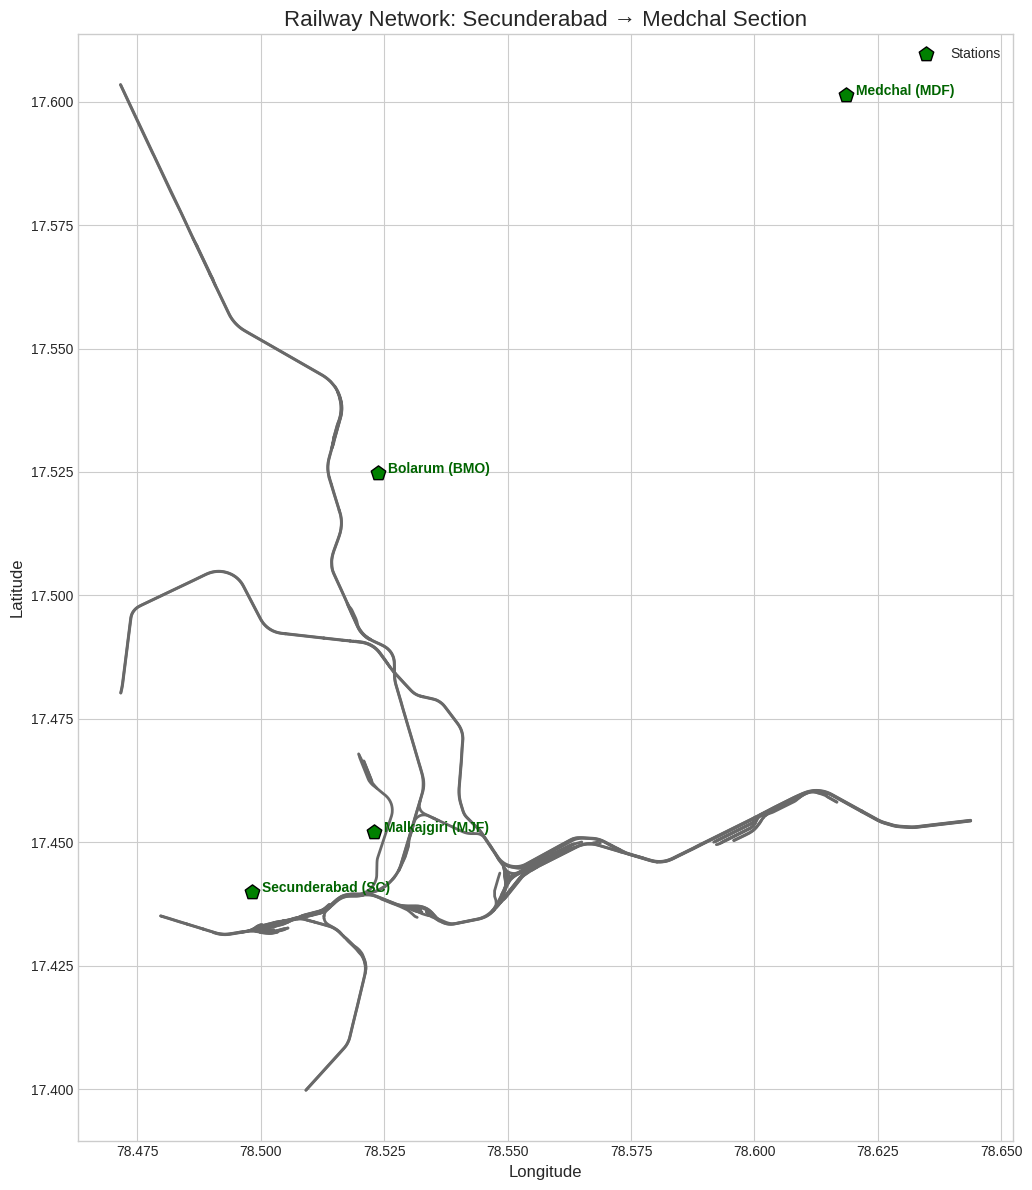

In [7]:
import requests
import matplotlib.pyplot as plt
import time

# -------------------------------
# Step 1: Define bounding box around Secunderabad → Medchal
# CORRECTED: The bounding box has been expanded to include all stations from Secunderabad to Medchal.
south, west = 17.43, 78.48
north, east = 17.63, 78.63


# -------------------------------
# Step 2: Build Overpass QL query
ql = f"""
[out:json][timeout:25];
(
  way["railway"="rail"]({south},{west},{north},{east});
  node["railway"="signal"]({south},{west},{north},{east});
  node["railway"="level_crossing"]({south},{west},{north},{east});
  node["railway"="junction"]({south},{west},{north},{east});
);
out body;
>;
out skel qt;
"""

# -------------------------------
# Step 3: Fetch data with retries
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

def fetch_overpass_data(query, retries=3, delay=5):
    """Fetches data from the Overpass API with retry logic."""
    print("Fetching data from Overpass API...")
    for attempt in range(1, retries + 1):
        try:
            response = requests.post(OVERPASS_URL, data={"data": query}, timeout=60)
            if response.status_code == 200:
                print("Data fetched successfully.")
                return response.json()
            else:
                print(f"Attempt {attempt}: Bad status code {response.status_code}, retrying in {delay}s...")
        except requests.RequestException as e:
            print(f"Attempt {attempt}: Request failed ({e}), retrying in {delay}s...")
        except requests.JSONDecodeError as e:
            print(f"Attempt {attempt}: JSON decode failed ({e}), retrying in {delay}s...")
        time.sleep(delay)
    print("Failed to fetch data after multiple retries.")
    return None

osmd = fetch_overpass_data(ql)
if osmd is None:
    raise SystemExit("Could not retrieve data. Try again later or check the bounding box.")

# -------------------------------
# Step 4: Separate nodes and ways
nodes = {}
ways = []

for elem in osmd['elements']:
    if elem['type'] == 'node':
        nodes[elem['id']] = {
            "lat": elem['lat'],
            "lon": elem['lon'],
            "tags": elem.get('tags', {})
        }
    elif elem['type'] == 'way':
        ways.append({
            "id": elem['id'],
            "nodes": elem['nodes'],
            "tags": elem.get('tags', {})
        })

print(f"Processed {len(nodes)} nodes and {len(ways)} ways.")

# -------------------------------
# Step 5: Extract railway track lines
track_lines = []
for way in ways:
    if way['tags'].get('railway') == 'rail':
        line_coords = []
        for node_id in way['nodes']:
            if node_id in nodes:
                line_coords.append((nodes[node_id]['lat'], nodes[node_id]['lon']))
        if line_coords:
            track_lines.append(line_coords)

# -------------------------------
# Step 6: Extract signals, level crossings, and junctions
signals = []
level_crossings = []
junctions = []

for node_id, node in nodes.items():
    railway_tag = node['tags'].get('railway')
    if railway_tag == 'signal':
        signals.append((node['lat'], node['lon']))
    elif railway_tag == 'level_crossing':
        level_crossings.append((node['lat'], node['lon']))
    elif railway_tag == 'junction':
        junctions.append((node['lat'], node['lon']))

print(f"Found {len(track_lines)} track segments.")
print(f"Number of signals found: {len(signals)}")
print(f"Number of level crossings found: {len(level_crossings)}")
print(f"Number of junctions found: {len(junctions)}")

# -------------------------------
# Step 7: Add station markers (approx coordinates)
stations = {
    "Secunderabad (SC)": (17.4399, 78.4983),
    "Malkajgiri (MJF)": (17.4521, 78.5230),
    "Bolarum (BMO)": (17.5247, 78.5238),
    "Medchal (MDF)": (17.6013, 78.6185)
}

# -------------------------------
# Step 8: Plot the data
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 12))

# Plot tracks
for line in track_lines:
    lats, lons = zip(*line)
    plt.plot(lons, lats, color='dimgray', linewidth=2, solid_capstyle='round')

# Plot signals
if signals:
    lats, lons = zip(*signals)
    plt.scatter(lons, lats, color='red', s=40, label='Signals', zorder=5)

# Plot level crossings
if level_crossings:
    lats, lons = zip(*level_crossings)
    plt.scatter(lons, lats, color='blue', s=60, marker='x', label='Level Crossings', zorder=5)

# Plot junctions
if junctions:
    lats, lons = zip(*junctions)
    plt.scatter(lons, lats, color='darkorange', s=150, marker='*', label='Junctions', zorder=6)

# Plot stations
station_lons = [lon for lat, lon in stations.values()]
station_lats = [lat for lat, lon in stations.values()]
plt.scatter(station_lons, station_lats, color='green', s=120, marker='p', label='Stations', zorder=7, edgecolors='black')

for name, (lat, lon) in stations.items():
    plt.text(lon + 0.002, lat, name, fontsize=10, color='darkgreen', weight='bold')


plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("Railway Network: Secunderabad → Medchal Section", fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
plt.show()

